# Reviews analysis on European Luxury Hotels

# 0. Background and Introduction

Whether hotel managers like it or not, guest reviews are becoming an essential factor influencing people's booking/purchase. Think about our past experiences. When we are looking for vacation accommodation on Booking.com, we may unknowingly scroll down the screen to view reviews.

As reviews become more and more important, hotel owners need to start using them. The analysis of reviews can help hotels understand what customers think about themselves and understand whether the hotel meets customer expectations. This analysis can also contribute to building up user portraits based on the reviews, which is essential for formulating marketing strategies based on the role of the customer. In addition, hotels can also compare themselves with similar hotels in the same region to measure their competitiveness and better locate themselves.

The review on Booking.com has a significant feature. Reviewers should give positive and negative feelings separately when writing, as shown in the figure. For potential customers, this can help them better decide which hotel to choose. For owners, this can better help estimate customers' overall rating of the hotel through review text.

fig.1 - Reviewing process on Booking.com

This report will focus on luxury hotels in six famous European tourism nations and analyze their reviews on Booking.com. The analysis will mainly involve and try to answer these questions: What do customers care about hotels in different countries? Are customers' reviews of each hotel positive or negative? How to predict the guest's rating based on hotels' basic information, the reviewers' information, and their text evaluations? How to classify and locate hotels based on their ratings and reviews. How to cluster consumers and roughly describe their portraits?

## 1. Data loading and wrangling

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import geoviews as gv
import geoviews.tile_sources as gvts
import hvplot.pandas
import holoviews as hv
import seaborn as sns
import altair as alt

np.random.seed(42)

palette5 = ["#61a262","#1a7328","#f2b4ae","#f26a4b","#f25d50"]
palette4 = ["#61a262","#1a7328","#f2b4ae","#f25d50"]
palette2 = ["#61a262","#f26a4b"]


### Load hospital reviews data with API 

Set up environment variable for kaggle API.

In [3]:
# set Kaggle key to environment variable
os.environ["KAGGLE_USERNAME"] = "lanxiao1120"
os.environ["KAGGLE_KEY"] = "dc6f594f7f5b866e3aec880f88948cb8"

# !!users need to install kaggle package first
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

Load data from Kaggle with API.

In [4]:
#Signature: dataset_download_file(dataset, file_name, path=None, force=False, quiet=True)
# download file via API
api.dataset_download_file('jiashenliu/515k-hotel-reviews-data-in-europe','Hotel_Reviews.csv', path='data')
# read it
hotel_raw = pd.read_csv('data/Hotel_Reviews.csv.zip')

#hotel_raw.head()

### Wrangle data and join with country Boundaries

Transform data into geo data frame, transform date columns into date type, and trim data into those of 2016.

In [5]:
# set up coord
hotel = hotel_raw.copy()
hotel['geometry'] = gpd.points_from_xy(hotel['lng'], hotel['lat'])

# to geo df
hotel = gpd.GeoDataFrame(hotel, geometry="geometry", crs="EPSG:4326")

# convert crs to 3857
hotel = hotel.to_crs(epsg=3857)

# transform to date
hotel['Review_Date'] = pd.to_datetime(hotel['Review_Date'] ,format='%m/%d/%Y')

# trim into 2016
hotel = hotel.loc[hotel['Review_Date'] >= '2016-01-01']
hotel = hotel.loc[hotel['Review_Date'] < '2017-01-01']

hotel.head(n=2)

Hotel_Address  \
66   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
67   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

    Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
66                           194  2016-12-29            7.7  Hotel Arena   
67                           194  2016-12-28            7.7  Hotel Arena   

   Reviewer_Nationality                                    Negative_Review  \
66      United Kingdom    Asked for more coffee and sugars only got giv...   
67        South Africa    Room was not cleaned correctly Wine Champagne...   

    Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
66                                 40                     1403   
67                                 30                     1403   

                                      Positive_Review  \
66   Nice open room Bed plenty of room Bath room c...   
67   To begin with we were upgraded which made my ...   

    Review_Total_Positive_Word_Counts  \
66                                 28   
67                                 92   

    Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
66                                           7             9.2   
67                                           6             7.5   

                                                 Tags days_since_review  \
66  [' Leisure trip ', ' Couple ', ' Large King Ro...           217 day   
67  [' Leisure trip ', ' Couple ', ' Duplex Double...           218 day   

          lat       lng                        geometry  
66  52.360576  4.915968  POINT (547243.088 6865586.634)  
67  52.360576  4.915968  POINT (547243.088 6865586.634)

In [6]:
%%opts WMTS [width=800, height=800, xaxis=None, yaxis=None]

hotel_2017 = hotel.loc[hotel['Review_Date']>'2017-01-01']

#hotel_2017.hvplot(geo=True, tiles=True, crs=3857)

Load data of European countries, and spatial join with hotel data.

In [7]:
# get country data 
url = 'https://gisco-services.ec.europa.eu/distribution/v2/countries/geojson/CNTR_RG_01M_2020_3857.geojson'
country = gpd.read_file(url)
#select col
country = country[['NAME_ENGL','geometry']]
# spatial join
hotel_joined = gpd.sjoin(hotel, country, op='within', how='left').drop(['index_right'], axis=1)


Change the name of the column for country.

In [8]:
# change column name
hotel_joined = hotel_joined.rename(
    columns={"NAME_ENGL": "Country"}
)

hotel_joined.head(n=2)

Hotel_Address  \
66   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
67   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

    Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
66                           194  2016-12-29            7.7  Hotel Arena   
67                           194  2016-12-28            7.7  Hotel Arena   

   Reviewer_Nationality                                    Negative_Review  \
66      United Kingdom    Asked for more coffee and sugars only got giv...   
67        South Africa    Room was not cleaned correctly Wine Champagne...   

    Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
66                                 40                     1403   
67                                 30                     1403   

                                      Positive_Review  \
66   Nice open room Bed plenty of room Bath room c...   
67   To begin with we were upgraded which made my ...   

    Review_Total_Positive_Word_Counts  \
66                                 28   
67                                 92   

    Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
66                                           7             9.2   
67                                           6             7.5   

                                                 Tags days_since_review  \
66  [' Leisure trip ', ' Couple ', ' Large King Ro...           217 day   
67  [' Leisure trip ', ' Couple ', ' Duplex Double...           218 day   

          lat       lng                        geometry      Country  
66  52.360576  4.915968  POINT (547243.088 6865586.634)  Netherlands  
67  52.360576  4.915968  POINT (547243.088 6865586.634)  Netherlands

## 2. Exploratory analysis

##  3. Words frequency analysis & Interactive word clouds

What are the most commonly used words in hotel reviews? Analyzing it can help hotel owners understand the most valuable services that reviewers care about. 

So let's start with the comprehensive data. After removing the meaningless pause words, the four most common terms are in order: room, staff, location, and breakfast, which represent the four fields consumers care about most about hotel accommodation.

### Lower and split reviews

In [9]:
hotel_review = hotel_joined.copy()

hotel_review['Negative_Review'] = [review.lower().split() for review in hotel_review['Negative_Review']]
hotel_review['Positive_Review'] = [review.lower().split() for review in hotel_review['Positive_Review']]

### Remove stop words and punctuation

Load stop words and create a list.

In [10]:
import nltk
# download stop words
nltk.download('stopwords');

#Get the list of common stop words
stop_words = list(set(nltk.corpus.stopwords.words('english')))

[nltk_data] Downloading package stopwords to /Users/lexi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load common punctuation and create a list.

In [11]:
import string

punctuation = list(string.punctuation)

Remove stop words and punctuation from our reviews.

In [12]:
# list to remove
ignored = stop_words + punctuation

# Remove from each review column
hotel_review['Negative_Review'] = [[word for word in review if word not in ignored]
              for review in hotel_review['Negative_Review']]
hotel_review['Positive_Review'] = [[word for word in review if word not in ignored]
              for review in hotel_review['Positive_Review']]

### Count word frequencies first time

Create a new column containing both positive review and negative review.

In [13]:
hotel_review['Total_Review'] = pd.concat([hotel_review['Negative_Review'],hotel_review['Positive_Review']], 
                                         ignore_index=True)

hotel_review.head(n=2)

Hotel_Address  \
66   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
67   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

    Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
66                           194  2016-12-29            7.7  Hotel Arena   
67                           194  2016-12-28            7.7  Hotel Arena   

   Reviewer_Nationality                                    Negative_Review  \
66      United Kingdom   [asked, coffee, sugars, got, given, two, satch...   
67        South Africa   [room, cleaned, correctly, wine, champagne, gl...   

    Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
66                                 40                     1403   
67                                 30                     1403   

                                      Positive_Review  \
66  [nice, open, room, bed, plenty, room, bath, ro...   
67  [begin, upgraded, made, wife, happy, room, spa...   

    Review_Total_Positive_Word_Counts  \
66                                 28   
67                                 92   

    Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
66                                           7             9.2   
67                                           6             7.5   

                                                 Tags days_since_review  \
66  [' Leisure trip ', ' Couple ', ' Large King Ro...           217 day   
67  [' Leisure trip ', ' Couple ', ' Duplex Double...           218 day   

          lat       lng                        geometry      Country  \
66  52.360576  4.915968  POINT (547243.088 6865586.634)  Netherlands   
67  52.360576  4.915968  POINT (547243.088 6865586.634)  Netherlands   

                                         Total_Review  
66  [would, nice, one, responsible, cleaning, room...  
67  [first, impressions, dark, reception, made, us...

Define a helper function to calculate word frequencies from our data frame with other information.

In [14]:
def count_word(review_col, top=20):
    """
    Given a column of all words for every rhotel, count word frequencies across all reviews.
    
    By default, this returns the top 20 words, but you can specify a different value for `top`.
    """
    import itertools, collections
    
    # List of all words across hotels
    all_words = list(itertools.chain(*review_col))

    # Create counter
    counter = collections.Counter(all_words)
    
    return pd.DataFrame(counter.most_common(top),
                        columns=['words', 'count'])

In [15]:
counts_reviews = count_word(hotel_review['Total_Review'], top=20)
counts_reviews

words  count
0          room  81858
1         staff  60017
2      location  52072
3         hotel  49687
4     breakfast  37343
5          good  34250
6      negative  33003
7         great  30074
8      friendly  22985
9           bed  21364
10      helpful  20890
11         nice  20414
12        rooms  19758
13        clean  19532
14  comfortable  17272
15    excellent  16847
16        small  15940
17        would  13129
18         stay  12758
19      nothing  12120

### Remove words that are not helpful

Remove words that are not very helpful for analysis.

In [16]:
neutral_words = ["nothing", "hotel", "would","could","one","bit","little","us","get","time","really","also","even"]
hotel_review['Total_Review'] = [[word for word in review if word not in neutral_words]
              for review in hotel_review['Total_Review']]

### Count words frequency for the final cleaned reviews

In [17]:
counts_reviews = count_word(hotel_review['Total_Review'], top=20)
counts_reviews

words  count
0          room  81858
1         staff  60017
2      location  52072
3     breakfast  37343
4          good  34250
5      negative  33003
6         great  30074
7      friendly  22985
8           bed  21364
9       helpful  20890
10         nice  20414
11        rooms  19758
12        clean  19532
13  comfortable  17272
14    excellent  16847
15        small  15940
16         stay  12758
17      service  11693
18     bathroom  11202
19          bar  10172

Plot the words frequency result.

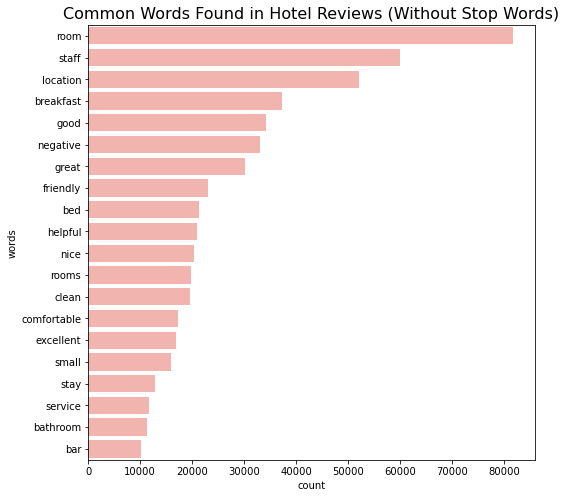

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(
    y="words",
    x="count",
    data=counts_reviews.sort_values(by="count", ascending=False),
    ax=ax,
    color=palette4[2],
    saturation=1.0,
)

ax.set_title("Common Words Found in Hotel Reviews (Without Stop Words)", fontsize=16);

### Define functions to plot word clouds from word frequency

However, the focus does vary with the country and its tourism characteristics. So an interactive word cloud is made by the country and the largest number of words to show. 

As the results show, people are most concerned about the location and staff services in the Netherlands, Italy, Spain, and Austria, and there are more positive words in the evaluation (good, great, friendly, Etc.). In the UK, people are more concerned about rooms conditions and staff services, and the frequency of 'negative' is higher in reviews. In France, people pay more attention to rooms and breakfast, and negative words (negative, small, Etc.) appear more frequently. 

What's more, each country has its unique characteristics. For example, reviewers in France pay more attention to the night experience and shower experience.

In [30]:
import multidict as multidict
import numpy as np
import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools, collections


def getFrequencyDictForText(sentence): 
    
    """
    Given a list of all words from all reviews, count word frequencies across all reviews, 
    return a dictionary of word and frequency.
    
    """

    # get frequency
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict

        
def plot_cloud(Country, Maximum=50,df=hotel_review, select_col='Country', text_col='Total_Review', title="Most used words in reviews by country"):
    """
    Given a dataframe, the column to interact with, the column with review text, 
    selected the country to analyze, maxmium word to display, title to show,
    generate a word cloud.
    
    """
        
    # select country 
    df_filtered = df.loc[df[select_col]==Country]
    # put all review words into one string object.
    all_words_list = list(itertools.chain(*df_filtered[text_col]))
    all_words = ''
    for word in all_words_list:
        all_words += " " + word
    
    # load base pic
    #alice_mask = np.array(Image.open("image/europe.png"))

    # set up word clooud
    wc = WordCloud(background_color="white", 
                   max_words=Maximum,
                   width=1500,       
                   height=960,          
                   margin=10)
    
    # generate word cloud
    wc.generate_from_frequencies(getFrequencyDictForText(all_words))
    
    # show
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=40,fontweight="bold")
    plt.figure()
    

### Implement interactivity

Obtain a list of all countries.

In [20]:
list1 = list(hotel_review['Country'].unique())

# remove nan
list1 = list1[0:3]+list1[4:7]

list1

['Netherlands', 'United Kingdom', 'France', 'Spain', 'Austria', 'Italy']

Create interactive word clouds.

In [23]:
from ipywidgets import widgets, interact, interactive, fixed
import spacy

a = interact(plot_cloud, 
         df=fixed(hotel_review), 
         select_col = fixed('Country'), 
         text_col = fixed('Total_Review'),
         Country = list1, 
         Maximum=[20,50,100,150],
         title = fixed("Most used words in reviews by country"),
        )

interactive(children=(Dropdown(description='Country', options=('Netherlands', 'United Kingdom', 'France', 'Spa…

Row
    [0] Column
        [0] Markdown(str)
        [1] Column
            [0] Select(name='Country', options=['Netherlands', ...], value='Netherlands')
            [1] DiscreteSlider(formatter='%d', name='Maximum', options=[20, 50, 100, 150], value=50)
    [1] Row
        [0] Str(None, name='interactive03778')

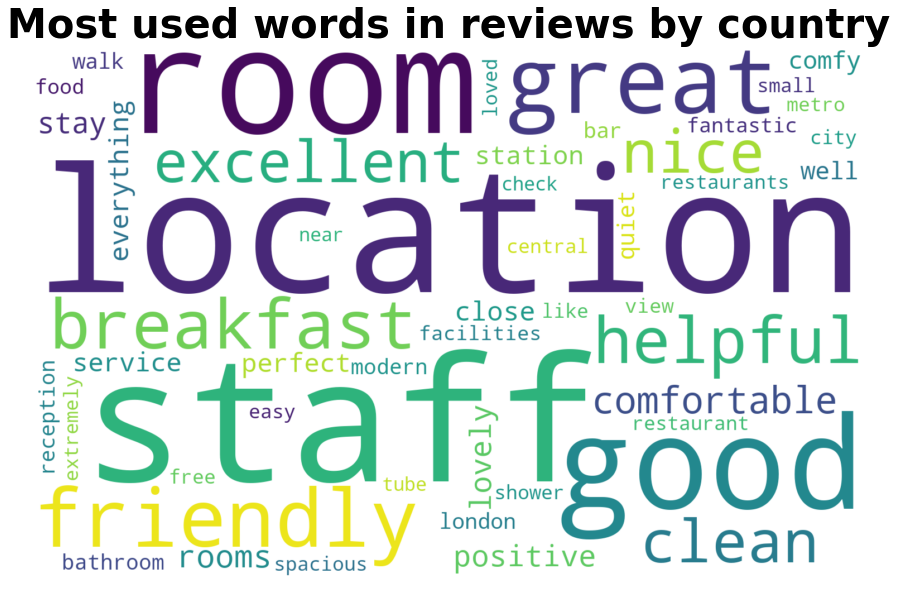

<Figure size 432x288 with 0 Axes>

In [31]:
list2 = [20,50,100,150]

# Load panel and enable interactive features
import panel as pn
pn.extension()

# Auto-generate the layout
layout = pn.interact(plot_cloud, Country=list1, Maximum=list2)

# Create the dashboard with a Row and Column
interact_dashboard = pn.Row(pn.Column('## MPG Explorer', layout[0]), layout[1])
interact_dashboard

## 4. Sentiment analysis

Are customers' reviews of each hotel positive or negative, subjective or objective? Let's analyze negative, positive, and integrated reviews.

### Create "text blobs" and pass text to

We create three text bolbs here, one for negative reviews, one for positive reviews, and one for total reviews.

In [26]:
import textblob

# concat positive and negative reviews together
hotel_review_raw = hotel_joined.copy()
hotel_review_raw['Total_Review'] = pd.concat([hotel_review_raw['Negative_Review'],hotel_review_raw['Positive_Review']], 
                                             ignore_index=True)

blobs_total = [textblob.TextBlob(review) for review in hotel_review_raw['Total_Review']]
blobs_neg = [textblob.TextBlob(review) for review in hotel_review_raw['Negative_Review']]
blobs_pos = [textblob.TextBlob(review) for review in hotel_review_raw['Positive_Review']]

### Combine all sentiment data into a DataFrame

In [27]:
hotel_sentiment = hotel_review_raw.copy()

hotel_sentiment['total_polarity'] = [blob.sentiment.polarity for blob in blobs_total]
hotel_sentiment['total_subjectivity'] = [blob.sentiment.subjectivity for blob in blobs_total]

hotel_sentiment['neg_polarity'] = [blob.sentiment.polarity for blob in blobs_neg]
hotel_sentiment['neg_subjectivity'] = [blob.sentiment.subjectivity for blob in blobs_neg]

hotel_sentiment['pos_polarity'] = [blob.sentiment.polarity for blob in blobs_pos]
hotel_sentiment['pos_subjectivity'] = [blob.sentiment.subjectivity for blob in blobs_pos]

hotel_sentiment.head()

Hotel_Address  \
66   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
67   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
68   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
69   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
70   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

    Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
66                           194  2016-12-29            7.7  Hotel Arena   
67                           194  2016-12-28            7.7  Hotel Arena   
68                           194  2016-12-21            7.7  Hotel Arena   
69                           194  2016-12-20            7.7  Hotel Arena   
70                           194  2016-12-19            7.7  Hotel Arena   

      Reviewer_Nationality                                    Negative_Review  \
66         United Kingdom    Asked for more coffee and sugars only got giv...   
67           South Africa    Room was not cleaned correctly Wine Champagne...   
68   United Arab Emirates    The bathroom was amazing Though we were two f...   
69         United Kingdom    Our room didn t have a sofa in but these two ...   
70                Germany    The breakfast was rather average from quality...   

    Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
66                                 40                     1403   
67                                 30                     1403   
68                                 35                     1403   
69                                 46                     1403   
70                                 55                     1403   

                                      Positive_Review  ...       lng  \
66   Nice open room Bed plenty of room Bath room c...  ...  4.915968   
67   To begin with we were upgraded which made my ...  ...  4.915968   
68   Beautiful design comfortable room friendly st...  ...  4.915968   
69   The bath and shower room was amazing Beautifu...  ...  4.915968   
70   The building was fantastic All renovated area...  ...  4.915968   

                          geometry      Country  \
66  POINT (547243.088 6865586.634)  Netherlands   
67  POINT (547243.088 6865586.634)  Netherlands   
68  POINT (547243.088 6865586.634)  Netherlands   
69  POINT (547243.088 6865586.634)  Netherlands   
70  POINT (547243.088 6865586.634)  Netherlands   

                                         Total_Review total_polarity  \
66   It would have been nice if the one responsibl...       0.232963   
67   First impressions of the dark reception made ...       0.050000   
68   Foyer was a mess Only place to relax was the ...      -0.063297   
69   the club sandwiches cold bacon with congealed...      -0.573333   
70   The only complaint we had was the iron in the...      -0.044444   

    total_subjectivity  neg_polarity neg_subjectivity pos_polarity  \
66            0.708025      0.054667         0.517333     0.366667   
67            0.388889     -0.400000         0.533333     0.451547   
68            0.584928      0.050000         0.950000     0.391667   
69            0.910000     -0.051389         0.497222     0.425000   
70            0.511111      0.211111         0.443519     0.534375   

   pos_subjectivity  
66         0.772222  
67         0.686869  
68         0.610000  
69         0.800000  
70         0.787500  

[5 rows x 26 columns]

### Count how many reviews are overall unbiased

In [28]:
zero = (hotel_sentiment['total_polarity']==0).sum()
print("Number of unbiased reviews: ", zero)
print("Proportion of unbiased reviews: ", round(zero/len(hotel_sentiment)*100,2),"%")

Number of unbiased reviews:  45595
Proportion of unbiased reviews:  17.24 %


### The distribution of subjectivity

Polarity runs from -1 (most negative) to +1 (most positive). Plot the histograms of the polarities of positive, negative and integrated reviews together with different colors. We can see that the polarity of negative reviews is concentrated in 0-0.2, while the polarity of positive reviews is concentrated in the range of 0.3-0.7, which proves that the algorithm's evaluation value of review sentiment is larger than the normal one. Therefore, the polarity of the true neutral evaluation should be slightly greater than 0. 

Then we look at the polarity distribution of the integrated reviews. Most polarities are near 0, which represents slightly negative feelings, and some are in the range of  -0.2 to -0.1, which means strongly negative emotions. Also, some polarities are more evenly distributed in the field of 0.3-0.7, while a small number of polarities are more significant than 0.7. 

In summary, positive reviews are a bit more than negative reviews overall, but some negative reviews are very extreme. This result enlightens hotel managers that the most important thing to pay attention to is to reduce the appearance of these extremely negative comments, that is, to prioritize improving the shortest board rather than further optimizing the existing advantages.

In [29]:
columns = ['neg_polarity', 'pos_polarity', 'total_polarity']

hotel_sentiment.hvplot.hist(y=columns, 
                            alpha=0.3, 
                            legend='right',
                            title = "The distribution of subjectivity by review classification")

:NdOverlay   [Element]
   :Histogram   [total_polarity]   (total_polarity_count)

In [30]:
print("The average polarity of integrated reviews:",round(hotel_sentiment['total_polarity'].mean(),4))
print("The median polarity of integrated reviews:",round(hotel_sentiment['total_polarity'].median(),4))

The average polarity of integrated reviews: 0.2052
The median polarity of integrated reviews: 0.15


In [31]:
print("The average polarity of positive reviews:",round(hotel_sentiment['pos_polarity'].mean(),4))
print("The median polarity of positive reviews:",round(hotel_sentiment['pos_polarity'].median(),4))

The average polarity of positive reviews: 0.3801
The median polarity of positive reviews: 0.4


In [32]:
print("The average polarity of negative reviews:",round(hotel_sentiment['neg_polarity'].mean(),4))
print("The median polarity of negative reviews:",round(hotel_sentiment['neg_polarity'].median(),4))

The average polarity of negative reviews: 0.0355
The median polarity of negative reviews: 0.0


### The distribution of subjectivity

The subjectivity of negative reviews is more concentrated at 0.4 and below, while positive reviews are more distributed above 0.5. It indicates that negative consumer reviews are often more objective than positive ones. Therefore, if hotels want to increase the number of positive reviews, it's best to provide customers with higher emotional value, such as low-cost surprise gifts or services, and a significantly warm attitude.

In [33]:
columns = ['neg_subjectivity', 'pos_subjectivity', 'total_subjectivity']

hotel_sentiment.hvplot.hist(y=columns, 
                            alpha=0.3, 
                            legend='right',
                            title = "The distribution of subjectivity by review classification")

:NdOverlay   [Element]
   :Histogram   [total_subjectivity]   (total_subjectivity_count)

### Explore the monthly trend of polarity

At last, explore the monthly trend of polarity and subjectivity. Interestingly, the reviewers' comments text will be more positive and subjective in the summer. This phenomenon may be because the weather and temperature will affect the users' mood or experience. In any case, it means that European hotels need to pay more attention to maintaining user experience, complaints, and evaluations in winter.

Sort the reviews in chronological order.

In [34]:
# sort 
hotel_sentiment = hotel_sentiment.sort_values(by='Review_Date', ascending=True)

# get month
import datetime as dt
hotel_sentiment['month'] = hotel_sentiment['Review_Date'].dt.month_name()


Make a box and whiskers plot of the polarity.

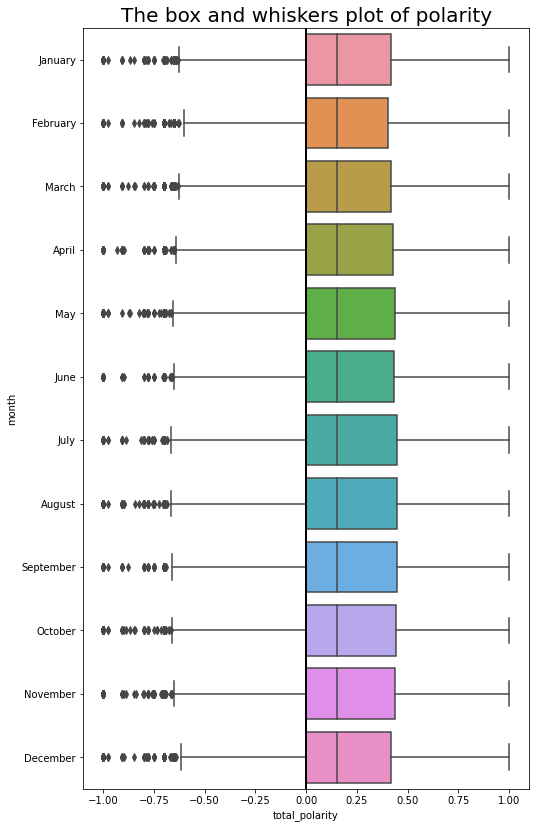

In [35]:
fig, ax = plt.subplots(figsize=(8, 14))

sns.boxplot(y='month', x='total_polarity', data=hotel_sentiment, ax=ax)
ax.axvline(x=0, c='k', lw=2) # neutral

ax.set_title("The box and whiskers plot of polarity", fontsize=20);
plt.setp(ax.get_yticklabels(), fontsize=10);

### Explore the monthly trend of subjectivity

Make a box and whiskers plot of the subjectivity.

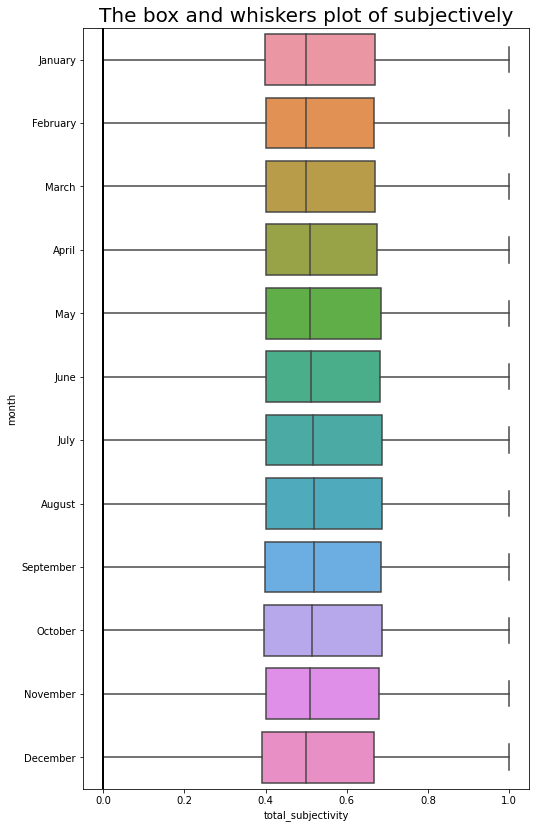

In [36]:
fig, ax = plt.subplots(figsize=(8, 14))

sns.boxplot(y='month', x='total_subjectivity', data=hotel_sentiment, ax=ax)
ax.axvline(x=0, c='k', lw=2) # neutral

# Set yticks to every other month
#yticks = ax.get_yticks()
#ax.set_yticks(range(0, len(yticks), 2))
ax.set_title("The box and whiskers plot of subjectively", fontsize=20);
plt.setp(ax.get_yticklabels(), fontsize=10);

## 5. Predict scores from reviewers

Is a customer's rating of a hotel predictable? What relationship do the customer's review text and the rating give? I try to build a random forest model to predict the rating score of any given reviewer. Through this model, not only can hotels collect customer reviews in advance to predict the customer's potential scores and make corresponding countermeasures, but also can dig out most significant predictors to better understand and manage their average scores.

The final model is based on the hotels' situation:

the current average score

the total number of reviews

scores from non-reviewers 

the located country

and specific reviewer information:

information related to the review text

the last review time

the total review number

nationality of the reviewer

the month of comments


### Train a Random Forest

Clean and trim data into the one we will directly fit on.

In [492]:
# The feature columns we want to use
cols = [
    "Reviewer_Score",
    "total_polarity",
    "pos_polarity",
    "neg_polarity",
    "total_subjectivity",
    "pos_subjectivity",
    "neg_subjectivity",
    "month",
    "Country",
    "Average_Score",
    "Reviewer_Nationality",
    "Review_Total_Negative_Word_Counts",
    "Review_Total_Positive_Word_Counts",
    "Total_Number_of_Reviews_Reviewer_Has_Given",
    "Total_Number_of_Reviews",
    "days_since_review",
    "Additional_Number_of_Scoring"
    
]

# reset index
#hotel_sentiment.set_index('index')

# Trim to these columns and remove NaNs
hotel_predict = hotel_sentiment[cols].copy().dropna()

# convert days_since_review	 from string to Integers 
hotel_predict['days_since_review'] = [row.split() for row in hotel_predict['days_since_review']]
hotel_predict['days_since_review'] = [row[0] for row in hotel_predict['days_since_review']]
hotel_predict['days_since_review'] = hotel_predict['days_since_review'].astype(float)


hotel_predict.head()

Reviewer_Score  total_polarity  pos_polarity  neg_polarity  \
79826              7.5       -0.125000      0.000000          0.00   
444094             5.0        0.436905      0.000000          0.00   
444095             8.3        0.687500      0.443333          0.15   
444096             9.6        0.533333      0.533333         -0.70   
510693            10.0        0.325000      0.900000          0.15   

        total_subjectivity  pos_subjectivity  neg_subjectivity    month  \
79826             0.700000          0.000000               0.0  January   
444094            0.672619          0.000000               0.0  January   
444095            0.750000          0.670556               0.4  January   
444096            0.550000          0.650000               1.0  January   
510693            0.558333          0.875000               0.4  January   

               Country  Average_Score Reviewer_Nationality  \
79826   United Kingdom            8.0              Kuwait    
444094  United Kingdom            8.1      United Kingdom    
444095  United Kingdom            8.1      United Kingdom    
444096  United Kingdom            8.1             Belgium    
510693     Netherlands            8.7        Saudi Arabia    

        Review_Total_Negative_Word_Counts  Review_Total_Positive_Word_Counts  \
79826                                   6                                  2   
444094                                  4                                  5   
444095                                  0                                 16   
444096                                  4                                  7   
510693                                  0                                 10   

        Total_Number_of_Reviews_Reviewer_Has_Given  Total_Number_of_Reviews  \
79826                                            2                     1786   
444094                                           4                     7105   
444095                                           7                     7105   
444096                                          20                     7105   
510693                                           8                     7656   

        days_since_review  Additional_Number_of_Scoring  
79826               580.0                           355  
444094              580.0                          1831  
444095              580.0                          1831  
444096              580.0                          1831  
510693              580.0                           975

One-hot encoding

In [493]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Initialize the OHE transformer
ohe = OneHotEncoder()

# Numerical columns
num_cols = [
    "total_polarity",
    "pos_polarity",
    "neg_polarity",
    "total_subjectivity",
    "pos_subjectivity",
    "neg_subjectivity",
    "Average_Score",
    "Review_Total_Negative_Word_Counts",
    "Review_Total_Positive_Word_Counts",
    "Total_Number_of_Reviews_Reviewer_Has_Given",
    "Total_Number_of_Reviews",
    "days_since_review",
    "Additional_Number_of_Scoring"
]

# Categorical columns
cat_cols = [
    "month",
    "Country",
    "Reviewer_Nationality",
]

# Set up the column transformer with two transformers
transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

Bacause total data is too large, randomly select 10,000 observations to build up a data set for regression.

In [494]:
import random
 
hotel_predict = hotel_predict.sample(n=10000, replace=False, random_state=42, axis=0)
len(hotel_predict)

10000

Split data into train and test sets as 7:3.

In [495]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


# The features
feature_cols = [
    "total_polarity",
    "pos_polarity",
    "neg_polarity",
    "total_subjectivity",
    "pos_subjectivity",
    "neg_subjectivity",
    "month",
    "Country",
    "Average_Score",
    "Reviewer_Nationality",
    "Review_Total_Negative_Word_Counts",
    "Review_Total_Positive_Word_Counts",
    "Total_Number_of_Reviews_Reviewer_Has_Given",
    "Total_Number_of_Reviews",
    "days_since_review",
    "Additional_Number_of_Scoring"
]

# Split the data 70/30
train_set, test_set = train_test_split(hotel_predict, test_size=0.3, random_state=42)

# the target labels
y_train = train_set["Reviewer_Score"].values
y_test = test_set["Reviewer_Score"].values

x_train = train_set[feature_cols].values
x_test = test_set[feature_cols].values

Create random forest pipeline and run it.

In [496]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

# Initialize the pipeline
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=100, 
                                       random_state=42)
)
# Fit the training set
pipe.fit(train_set, y_train);

# What's the test score?
pipe.score(test_set, y_test)

0.44579402490482245

Perform a 𝑘 -fold cross validation to optimize hyperparameters.

In [520]:
# Make the grid of parameters to search
"""
model_step = "randomforestregressor"
param_grid = {
    f"{model_step}__n_estimators": [15, 100, 200, 400, 600],
    f"{model_step}__max_depth": [5, 7, 13, 51],
}


# Create the grid and use 3-fold CV
grid = GridSearchCV(pipe, param_grid, cv=3)

# Run the search
grid.fit(train_set, y_train)

# The best estimator
grid.best_estimator_


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['total_polarity',
                                                   'pos_polarity',
                                                   'neg_polarity',
                                                   'total_subjectivity',
                                                   'pos_subjectivity',
                                                   'neg_subjectivity',
                                                   'Average_Score',
                                                   'Review_Total_Negative_Word_Counts',
                                                   'Review_Total_Positive_Word_Counts',
                                                   'Total_Number_of_Reviews_Reviewer_Has_Given',
                                                   'Total_Number_of_Reviews',
                                                  

Evaluate the score with the new model.

In [521]:
# Initialize the optimized pipeline
pipe2 = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=600, 
                                       max_depth=13,
                                       random_state=42)
)
# Fit the training set
pipe2.fit(train_set, y_train);

# What's the test score?
scores = pipe2.score(test_set, y_test)
print("R^2 scores = ", scores)

R^2 scores =  0.4530901728777158


### The percent error of predictions

Define a function to calculate the MAE (Mean Absolute Error) and MAPE (Mean Absolute Percentage Error). 

In [498]:
def evaluate(model, X_test, y_test):
    """
    Given a model and test features/targets, print out the 
    MAE and MAPE
    """
    # Make the predictions
    predictions = model.predict(X_test)

    # Absolute error
    errors = abs(predictions - y_test)
    avg_error = np.mean(errors)

    # Mean absolute percentage error
    mean_percent_error = 100 * np.mean(errors / y_test)
    median_percent_error = 100 * np.median(errors / y_test)
    percent_error = (errors / y_test).tolist()


    print("Model Performance:")
    print(f"Mean Absolute Error: {avg_error:0.4f}")
    print(f"Mean percentage error = {mean_percent_error:0.2f}%.")

    #return percent_error

In [522]:
# Evaluate on test set
percent_error = evaluate(pipe2, test_set, y_test)

Model Performance:
Mean Absolute Error: 0.9079
Mean percentage error = 13.25%.


### Check Vthe significance of numerical ariables

The score of this model is 0.45, and the mean percentage error is 13%. The hotel can input the user's comment text obtained in advance to predict the score and carry out corresponding countermeasures.

At the same time, we can see that the most important predictors are:

the number of words in negative reviews given by reviewers

the polarity of positive reviews

the current average hotel score

Therefore, just like the sentiment analysis conclusion, to improve the overall scores, the hotels should try to make up for the shortcomings to reduce the factors that can be criticized, and provide users with higher emotional value.

In [523]:
# Get the forest model
forest_model = pipe2['randomforestregressor']

# Create the data frame of importances
importance = pd.DataFrame(
    {"Feature": num_cols, "Importance": list(regressor.feature_importances_)[0:13]}
)
importance.hvplot.barh(x="Feature", y="Importance")

:Bars   [Feature]   (Importance)

## 6. Clustering hotels based on DBSCAN

### Select and engineer features

In [210]:
feature_columns = [
    'Hotel_Name',
    'Average_Score', 
    'Total_Number_of_Reviews', 
    'total_subjectivity'
]

# select features
hotel_cluster = hotel_sentiment[feature_columns].copy()

# group by hotel and calculate mean
hotel_cluster = hotel_cluster.groupby('Hotel_Name').mean().reset_index().dropna()

hotel_cluster.head()

Hotel_Name  Average_Score  Total_Number_of_Reviews  \
0                  11 Cadogan Gardens            8.7                    393.0   
1                            1K Hotel            7.7                    663.0   
2  25hours Hotel beim MuseumsQuartier            8.8                   4324.0   
3                                  41            9.6                    244.0   
4  45 Park Lane Dorchester Collection            9.4                     68.0   

   total_subjectivity  
0            0.488381  
1            0.399792  
2            0.604034  
3            0.324680  
4            0.442770

### Normalize features

In [211]:
from sklearn.preprocessing import StandardScaler

# drop hotel name
hotel_scaled = hotel_cluster.drop(['Hotel_Name'], axis=1)

# Scale these features
scaler = StandardScaler()
hotel_scaled = scaler.fit_transform(hotel_scaled)

hotel_scaled

array([[ 0.44364563, -0.67491521,  0.01049934],
       [-1.39199299, -0.47888846, -0.84116048],
       [ 0.62720949,  2.17908913,  1.12234468],
       ...,
       [ 1.17790108,  2.43174583, -0.93601578],
       [ 0.62720949,  0.26310911, -0.58306978],
       [ 0.07651791, -0.3757929 ,  1.37191062]])

### Run DBSCAN to extract high-density clusters

In [241]:
from sklearn.cluster import dbscan 

# Run DBSCAN 
cores, labels = dbscan(hotel_scaled, eps=0.38, min_samples=30)

# Add the labels back to the original (unscaled) dataset
hotel_cluster['label'] = labels

# Extract the number of clusters 
num_clusters = hotel_cluster['label'].nunique() - 1
print("The number of clusters", num_clusters)

The number of clusters 3


In [242]:
hotel_cluster.groupby('label').size()

label
-1    813
 0    409
 1    195
 2     40
dtype: int64

### Get mean statistics for clusters

In [195]:
# groupby by the label
grps = hotel_cluster.groupby('label')

# calculate average pickup hour and trip distance per cluster
avg_values = grps[[ 'Average_Score', 'Total_Number_of_Reviews', 'total_subjectivity']].mean().reset_index()

avg_values

label  Average_Score  Total_Number_of_Reviews  total_subjectivity
0     -1       8.057679              2576.573379            0.478019
1      0       8.565745               904.440219            0.486050
2      1       8.462500              3836.531250            0.589238
3      2       8.130000              3454.600000            0.571613

### Visualize the clusters

Join with other information that not involves clustering process. 

In [243]:
# merge with geometry
hotel_cluster = pd.merge(hotel_cluster, hotel_joined[['geometry','Hotel_Name','Country']],on=['Hotel_Name'], how='left').drop_duplicates()
hotel_cluster = gpd.GeoDataFrame(hotel_cluster, geometry="geometry", crs="EPSG:3857")

hotel_cluster.head()

Hotel_Name  Average_Score  \
0                    11 Cadogan Gardens            8.7   
81                             1K Hotel            7.7   
149  25hours Hotel beim MuseumsQuartier            8.8   
481                                  41            9.6   
529  45 Park Lane Dorchester Collection            9.4   

     Total_Number_of_Reviews  total_subjectivity  label  \
0                      393.0            0.488381      0   
81                     663.0            0.399792     -1   
149                   4324.0            0.604034     -1   
481                    244.0            0.324680     -1   
529                     68.0            0.442770     -1   

                            geometry         Country  
0     POINT (-17725.926 6709077.580)  United Kingdom  
81    POINT (263367.933 6251804.926)          France  
149  POINT (1820589.050 6141273.832)         Austria  
481   POINT (-15990.956 6709887.750)  United Kingdom  
529   POINT (-16868.899 6711358.422)  United Kingdom

### Plot relation between scores, subjectivity, and number of reviews, coloring by  labels

In [244]:
alt.Chart(hotel_cluster.loc[hotel_cluster['label']!=-1]
         ).mark_circle().encode(
    alt.X('total_subjectivity:Q', scale=alt.Scale(zero=False)),
    alt.Y('Average_Score:Q', scale=alt.Scale(zero=False)),
    size='Total_Number_of_Reviews:Q',
    color=alt.Color('label:N', scale=alt.Scale(scheme='dark2')),
    tooltip=list(hotel_cluster.columns)
).interactive().properties(width=800)



/Users/lexi/opt/anaconda3/envs/musa-550-fall-2021/lib/python3.8/site-packages/altair/utils/core.py:185: UserWarning: I don't know how to infer vegalite type from 'unknown-array'.  Defaulting to nominal.
  warnings.warn(


alt.Chart(...)

### Plot relation between scores, subjectivity, and number of reviews,, coloring by countries

In [247]:
alt.Chart(hotel_cluster.loc[hotel_cluster['label']!=-1]
         ).mark_circle().encode(
    alt.X('total_subjectivity:Q', scale=alt.Scale(zero=False)),
    alt.Y('Average_Score:Q', scale=alt.Scale(zero=False)),
    size='Total_Number_of_Reviews:Q',
    color=alt.Color('Country:N', scale=alt.Scale(scheme='dark2')),
    tooltip=list(hotel_cluster.columns)
).interactive().properties(width=800)



alt.Chart(...)

## 7. Clustering reviewers based on K-mean

### Select and engineer features

In [392]:
# create a col for total number of review words
hotel_cluster2 = hotel_sentiment.copy()
hotel_cluster2['Review_Total_Word_Counts'] = hotel_cluster2['Review_Total_Negative_Word_Counts']+hotel_cluster2['Review_Total_Positive_Word_Counts']


feature_columns = [
    'Review_Total_Word_Counts',
    'Total_Number_of_Reviews_Reviewer_Has_Given', 
    'days_since_review',
]

# select features
hotel_cluster2 = hotel_cluster2[feature_columns]

# convert days_since_review	 from string to Integers 
hotel_cluster2['days_since_review'] = [row.split() for row in hotel_cluster2['days_since_review']]
hotel_cluster2['days_since_review'] = [row[0] for row in hotel_cluster2['days_since_review']]
hotel_cluster2['days_since_review'] = hotel_cluster2['days_since_review'].astype(float)

# group by hotel and calculate mean
hotel_cluster2 = hotel_cluster2.dropna()

hotel_cluster2.head(n=2)

Review_Total_Word_Counts  Total_Number_of_Reviews_Reviewer_Has_Given  \
79826                          8                                           2   
444094                         9                                           4   

        days_since_review  
79826               580.0  
444094              580.0

### Fit clustering

In [393]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)

kmeans.fit(hotel_cluster2[['Review_Total_Word_Counts','Total_Number_of_Reviews_Reviewer_Has_Given', 'days_since_review']])

# Extract the labels
hotel_cluster2['label'] = kmeans.labels_

## Have a glimpse of cluster size

In [394]:
# Extract the number of clusters 
num_clusters2 = hotel_cluster2['label'].nunique() - 1
print("The number of clusters", num_clusters2)

The number of clusters 4


In [395]:
hotel_cluster2.groupby('label').size()

label
0    72220
1    61528
2    55479
3     8059
4    67117
dtype: int64

### Get mean statistics for clusters

In [396]:
# groupby by the label
grps = hotel_cluster2.groupby('label')

# calculate average pickup hour and trip distance per cluster
avg_values2 = grps[['Review_Total_Word_Counts','Total_Number_of_Reviews_Reviewer_Has_Given', 'days_since_review']].mean().reset_index()

avg_values2

label  Review_Total_Word_Counts  \
0      0                 29.976322   
1      1                 31.185834   
2      2                 33.225238   
3      3                178.679489   
4      4                 31.862807   

   Total_Number_of_Reviews_Reviewer_Has_Given  days_since_review  
0                                    6.885087         358.959360  
1                                    7.110242         449.567026  
2                                    7.553020         536.947277  
3                                    7.483062         376.536047  
4                                    7.200188         265.178494

### Visualize the clusters

### Plot relation between scores, subjectivity, and number of reviews, coloring by  labels

In [397]:
to_plot = hotel_cluster2.loc[hotel_cluster2['label']!=-1].drop_duplicates()

# data is so large, select some
to_plot = to_plot.sample(n=150, replace=False, random_state=42, axis=0)

to_plot.hvplot.scatter(x='Total_Number_of_Reviews_Reviewer_Has_Given', y='Review_Total_Word_Counts', by='label', 
                      legend='right', height=400, width=800,
                       size='days_since_review', alpha=0.3,
                      hover_cols=['Review_Total_Word_Counts','Total_Number_of_Reviews_Reviewer_Has_Given', 'days_since_review'])


:NdOverlay   [label]
   :Scatter   [Total_Number_of_Reviews_Reviewer_Has_Given]   (Review_Total_Word_Counts,days_since_review)

### Plot the radar map for reviewers

Normalize features of cluster centers.

In [419]:
cluster_centers = scaler.fit_transform(kmeans.cluster_centers_)

cluster_centers = pd.DataFrame(cluster_centers)

cluster_centers = cluster_centers.rename(
    columns={
        0: "Review_Total_Word_Counts", 
        1: "Total_Number_of_Reviews_Reviewer_Has_Given",
        2: "days_since_review"
    }
)

cluster_centers.head()

Review_Total_Word_Counts  Total_Number_of_Reviews_Reviewer_Has_Given  \
0                 -0.526900                                   -1.453618   
1                 -0.506250                                   -0.567293   
2                 -0.471211                                    1.265044   
3                  1.999677                                    0.960673   
4                 -0.495316                                   -0.204806   

   days_since_review  
0          -0.421293  
1           0.572578  
2           1.530126  
3          -0.232507  
4          -1.448904

Plot.

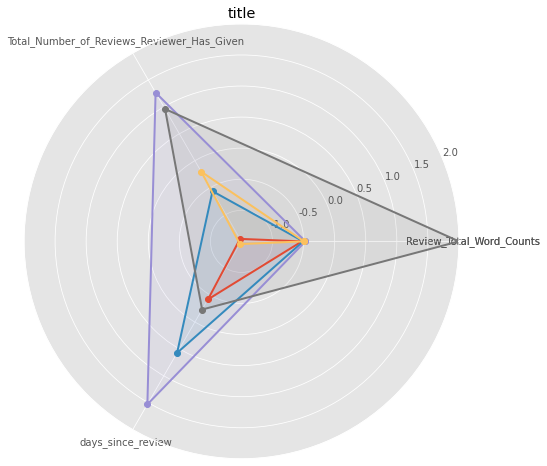

In [433]:
import numpy as np
import matplotlib.pyplot as plt
# 用于正常显示中文
plt.rcParams['font.sans-serif'] = 'SimHei'
#用于正常显示符号
plt.rcParams['axes.unicode_minus'] = False
 
# 使用ggplot的绘图风格，这个类似于美化了，可以通过plt.style.available查看可选值，你会发现其它的风格真的丑。。。
plt.style.use('ggplot')
 
# 构造数据
values1  = cluster_centers.loc[0,:].to_list()
values2  = cluster_centers.loc[1,:].to_list()
values3  = cluster_centers.loc[2,:].to_list()
values4  = cluster_centers.loc[3,:].to_list()
values5  = cluster_centers.loc[4,:].to_list()
feature = np.array(['Review_Total_Word_Counts','Total_Number_of_Reviews_Reviewer_Has_Given','days_since_review'])


# 设置每个数据点的显示位置，在雷达图上用角度表示
angles=np.linspace(0, 2*np.pi,len(feature), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
# 绘图
fig=plt.figure(figsize=(8,8))
# 设置为极坐标格式
ax = fig.add_subplot(111, polar=True)
for values in [values1, values2, values3, values4, values5]:
    values=np.concatenate((values,[values[0]]))
    # 绘制折线图
    ax.plot(angles, values, 'o-', linewidth=2)
    # 填充颜色
    ax.fill(angles, values, alpha=0.1) 
    # 设置图标上的角度划分刻度，为每个数据点处添加标签
    feature2 = np.concatenate((feature,[feature[0]]))
    ax.set_thetagrids(angles * 180/np.pi, feature2)
    ax.set_ylim(-1.5,2)

# 添加标题
plt.title('title')
# 添加网格线
ax.grid(True)
 
plt.show()

